# Equity Valuation

Create model for equities that, based on
* Balance Sheet (Revenue + Profit)
* INterest Rates + FX
* Market situation

Explains and predicts prices!


First, based on revenue projection, for each point in time calculate the implicit discount factor as per DCF method. Compare this to actual interest rates (+ expectations)

Estimate yield curves for DCF!


Revenue estimates:
* During Q1, there are alredy forecasts of Q2 - with some indication of uncertainty (lower, upper). Need to take these values as guidance for revenue forecasting!
* Quarterly data exhibit seasonality! Year-on-Year change needs to represents growth rate, but quarterly rate of changes need to be adjusted!!!
    * For each set of 8 data points: sum(1:4) / sum(5:8) == growth rate -> calculate as rolling window, such that there is always !! one !! unkown quarer

In [631]:
# Select few stocks: Microsoft, Apple, etc.
# Some good performers, and some bad performers.
# -> Maybe Top 10 companies in 2000? LIke Exxon, etc.

# TODO: Where to get revenue and number of shares data from? ideally yearly / quarterly for the last 5-10 years ???

In [632]:
# Check macrotrends.net
# https://www.macrotrends.net/stocks/charts/NFLX/netflix/income-statement?freq=Q
# -> NO programmatic access allowed! Data from zack investment research

# -> Quandl?

# -> PROBLEM: Most providers (even at 1.200USD / year) provide 5 year history only and sometimes even less for quaterly data
# -> MAYBE buy that later on! For development of code, that is too much!

In [633]:
import pandas as pd
import numpy as np

import yfinance as yf

from datetime import datetime, timedelta


import matplotlib.pyplot as plt
import seaborn as sns

## Import Data

In [634]:
# Import fundamentals

file_fundamentals = "C:/Users\phili\OneDrive\GitHub\Portfolio_Management\Data_Fundamentals.xlsx"

fundamentals = pd.read_excel(file_fundamentals, sheet_name=None, skiprows=12, nrows=23)
fundamentals.keys()

dict_keys(['NFLX', 'MSFT', 'AAPL', 'KO', 'AMZN'])

In [635]:
# Get prices

date_start = '2008-12-01'
date_end = datetime.today()

symbols = fundamentals.keys()
symbols = ' '.join(symbols)

data_prices = yf.download(tickers = symbols, interval = "1d", start = date_start, end = date_end, group_by = 'ticker')

[*********************100%***********************]  5 of 5 completed


In [636]:
# Get interest rates

tr_symbols = ['^TNX', '^FVX', '^TYX']
tr_symbols = ' '.join(tr_symbols)

data_tr = yf.download(tickers = tr_symbols, interval = "1d", start = date_start, end = date_end, group_by = 'ticker')

[*********************100%***********************]  3 of 3 completed


In [637]:
# Rename columns
data_tr = data_tr.rename(columns={'^TYX': 'TR_30Y', '^TNX': 'TR_10Y', '^FVX': 'TR_5Y'})

data_tr.tail()

TR_10Y                                       TR_30Y                \
             Open   High    Low  Close Adj Close Volume   Open   High    Low   
Date                                                                           
2022-06-08  3.009  3.040  2.988  3.029     3.029      0  3.157  3.186  3.139   
2022-06-09  3.053  3.073  3.020  3.044     3.044      0  3.187  3.210  3.158   
2022-06-10  3.040  3.178  2.994  3.156     3.156      0  3.158  3.238  3.098   
2022-06-13  3.282  3.366  3.246  3.366     3.366      0  3.293  3.389  3.268   
2022-06-14  3.349  3.483  3.483  3.483     3.483      0  3.350  3.432  3.432   

                                    TR_5Y                                 \
            Close Adj Close Volume   Open   High    Low  Close Adj Close   
Date                                                                       
2022-06-08  3.177     3.177      0  3.015  3.049  3.001  3.032     3.032   
2022-06-09  3.171     3.171      0  3.072  3.089  3.041  3.063     3.063   
2022-06-10  3.196     3.196      0  3.078  3.259  3.064  3.250     3.250   
2022-06-13  3.367     3.367      0  3.418  3.475  3.355  3.475     3.475   
2022-06-14  3.432     3.432      0  3.459  3.596  3.596  3.596     3.596   

                   
           Volume  
Date               
2022-06-08      0  
2022-06-09      0  
2022-06-10      0  
2022-06-13      0  
2022-06-14      0

In [638]:
# TODO: Get ccy

## Transform data

In [639]:
# Collect all data
df_temp = pd.DataFrame()

for sym, df in fundamentals.items():
    df = df.iloc[:,1:]
    df['Symbol'] = sym
    df_temp = df_temp.append(df)

In [640]:
# Transform to long format
df_fundamentals = (
    df_temp
    .reset_index(drop=True)
    .melt(id_vars=['Date', 'Symbol'])
    .pivot(index=['Symbol', 'variable'], columns='Date', values='value')
    .reset_index()
    .rename(columns={'variable':'Y_Q'})
)


In [641]:
# Transate Y_Q to datetime -> format as last day in quarter!
df_fundamentals["Y_Q"] = pd.PeriodIndex(df_fundamentals.Y_Q, freq = 'Q').to_timestamp()# - timedelta(days=1)
df_fundamentals.head()

Date,Symbol,Y_Q,Basic EPS,Basic Shares Outstanding,Cost of Goods Sold,EBIT,EBITDA,EPS,Gross Profit,Income After Taxes,...,Other Operating Income Or Expenses,Pre-Tax Income,R&D,Research And Development Expenses,Rev per Share,Revenue,SG%A,SG&A Expenses,Shares Outstanding,Total Non-Operating Income/Expense
0,AAPL,2005-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAPL,2005-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAPL,2005-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAPL,2005-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAPL,2006-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Prices + treasuries

In [642]:
# Reshape prices longer
df_prices = data_prices.stack(level = 0).rename_axis(['Date', 'Symbol']).reset_index(level = 1)

# Resetindex to make date-index a column that can be stored in files
df_prices = df_prices.reset_index()

# Sort columns and keep relevant ones, for now
df_prices = df_prices[['Symbol', 'Date', 'Adj Close', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Transform date colume to datetime
# df_prices['Date'] = pd.to_datetime(df_prices['Date'], format='%Y-%m-%d')

# By Symbol, fill missing dates with locf method
df_prices = df_prices.set_index('Date').groupby('Symbol').resample('1D')['Close'].ffill().reset_index()

df_prices.head()

,Symbol,Date,Close
0,AAPL,2008-12-01,3.176071
1,AAPL,2008-12-02,3.302500
2,AAPL,2008-12-03,3.425000
3,AAPL,2008-12-04,3.264643
4,AAPL,2008-12-05,3.357143


In [643]:
# Reshape prices longer
df_tr = data_tr.stack(level = 0).rename_axis(['Date', 'Symbol']).reset_index(level = 1)

# Resetindex to make date-index a column that can be stored in files
df_tr = df_tr.reset_index()

# Sort columns and keep relevant ones, for now
df_tr = df_tr[['Symbol', 'Date', 'Adj Close', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Transform date colume to datetime
# df_tr['Date'] = pd.to_datetime(df_tr['Date'], format='%Y-%m-%d')

# By Symbol, fill missing dates with locf method
df_tr = df_tr.set_index('Date').groupby('Symbol').resample('1D')['Close'].ffill().reset_index()

df_tr = df_tr.pivot(index='Date', columns='Symbol', values='Close').reset_index()



df_tr.head()

Symbol,Date,TR_10Y,TR_30Y,TR_5Y
0,2008-12-01,2.719,3.236,1.723
1,2008-12-02,2.693,3.202,1.672
2,2008-12-03,2.676,3.184,1.632
3,2008-12-04,2.570,3.084,1.534
4,2008-12-05,2.657,3.110,1.667


In [644]:
# Smooth! -> there are too many 1 day spikes which mess up the valuation!
df_tr = df_tr.set_index('Date').rolling(window=5).mean().reset_index()

<AxesSubplot:xlabel='Date', ylabel='value'>

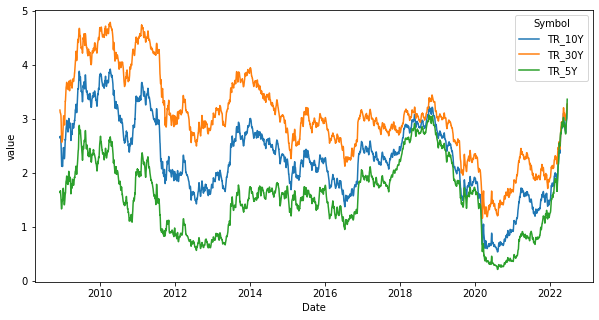

In [645]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=df_tr.melt(id_vars='Date'), x='Date', y='value', hue='Symbol')


## Valuation

### TODO: Improve revenue forecasting!

VaR ? simultaneous forecasting for several, competitive companies???

In [646]:
# Growth rate as: last 4 quarter divided by previous 4 quarters
gr_rate = lambda x: (x[4:].sum() / x[:4].sum()) - 1

df_fundamentals['Rev_growth'] = df_fundamentals.groupby(['Symbol'])[['Revenue']].transform(lambda x: x.rolling(8, min_periods=8).apply(gr_rate))
df_fundamentals.dropna(subset=['Rev_growth']).tail(10)


Date,Symbol,Y_Q,Basic EPS,Basic Shares Outstanding,Cost of Goods Sold,EBIT,EBITDA,EPS,Gross Profit,Income After Taxes,...,Pre-Tax Income,R&D,Research And Development Expenses,Rev per Share,Revenue,SG%A,SG&A Expenses,Shares Outstanding,Total Non-Operating Income/Expense,Rev_growth
339,NFLX,2019-10-01,1.340116,438.0,-3466.023,NaN,NaN,1.298608,2001.412,586.971,...,149.334,-409.376,NaN,12.482728,5467.435,-1133.523,NaN,452.0,NaN,0.276182
340,NFLX,2020-01-01,1.615187,439.0,-3599.701,NaN,NaN,1.568732,2167.990,709.067,...,795.870,-453.817,NaN,13.138248,5767.691,-755.917,NaN,452.0,NaN,0.288223
341,NFLX,2020-04-01,1.633098,441.0,-3643.707,NaN,NaN,1.586335,2504.579,720.196,...,1035.602,-435.045,NaN,13.941692,6148.286,-711.606,NaN,454.0,NaN,0.283489
342,NFLX,2020-07-01,1.787276,442.0,-3867.751,NaN,NaN,1.736211,2567.886,789.976,...,861.460,-453.802,NaN,14.560265,6435.637,-799.221,NaN,455.0,NaN,0.261879
343,NFLX,2020-10-01,1.229381,441.0,-4165.160,NaN,NaN,1.194178,2479.283,542.157,...,506.418,-486.936,NaN,15.066764,6644.443,-1038.104,NaN,454.0,NaN,0.240102
344,NFLX,2021-01-01,3.852630,443.0,-3868.511,NaN,NaN,3.742796,3294.771,1706.715,...,2034.502,-525.207,NaN,16.169937,7163.282,-809.708,NaN,456.0,NaN,0.233073
345,NFLX,2021-04-01,3.054205,443.0,-4018.008,NaN,NaN,2.973655,3323.769,1353.013,...,1593.789,-537.321,NaN,16.572860,7341.777,-938.818,NaN,455.0,NaN,0.219054
346,NFLX,2021-07-01,3.271041,443.0,-4206.589,NaN,NaN,3.184771,3276.878,1449.071,...,1660.959,-563.887,NaN,16.892702,7483.467,-957.738,NaN,455.0,NaN,0.202104
347,NFLX,2021-10-01,1.115745,443.0,-5239.576,NaN,NaN,1.086319,2469.741,494.275,...,550.851,-647.470,NaN,17.402521,7709.317,-1190.503,NaN,455.0,NaN,0.188101
348,NFLX,2022-01-01,3.561520,444.0,-4284.705,NaN,NaN,3.490762,3583.062,1581.315,...,1963.560,-657.530,NaN,17.720196,7867.767,-953.906,NaN,453.0,NaN,0.151968


In [647]:
# Calculate expected revenue of next 10 years

df_val = df_prices.set_index('Date').join(df_tr.set_index('Date'), on=['Date']).reset_index()

# Add rev + rev_growth
df_val = df_val.join(df_fundamentals[['Symbol', 'Y_Q', 'Revenue', 'Rev_growth', 'Shares Outstanding']].rename(columns={'Y_Q':'Date'}).set_index(['Date', 'Symbol']), on=['Date', 'Symbol'])

# Fill revenue + rev-growth forward
df_val[['Revenue', 'Rev_growth', 'Shares Outstanding']] = df_val.groupby('Symbol')[['Revenue', 'Rev_growth', 'Shares Outstanding']].ffill()

df_val



,Date,Symbol,Close,TR_10Y,TR_30Y,TR_5Y,Revenue,Rev_growth,Shares Outstanding
0,2008-12-01,AAPL,3.176071,NaN,NaN,NaN,NaN,NaN,NaN
1,2008-12-02,AAPL,3.302500,NaN,NaN,NaN,NaN,NaN,NaN
2,2008-12-03,AAPL,3.425000,NaN,NaN,NaN,NaN,NaN,NaN
3,2008-12-04,AAPL,3.264643,NaN,NaN,NaN,NaN,NaN,NaN
4,2008-12-05,AAPL,3.357143,2.6630,3.1632,1.6456,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
24715,2022-06-10,NFLX,182.940002,3.0478,3.1716,3.0728,7867.767,0.151968,453.0
24716,2022-06-11,NFLX,182.940002,3.0714,3.1726,3.1158,7867.767,0.151968,453.0
24717,2022-06-12,NFLX,182.940002,3.1082,3.1872,3.1690,7867.767,0.151968,453.0
24718,2022-06-13,NFLX,169.690002,3.1756,3.2252,3.2576,7867.767,0.151968,453.0


In [648]:
# Calculate revenue forecast and dcf

def calc_dcf(x):

    rev_t0 = x['Revenue']
    rev_gr = x['Rev_growth']
    r_disc_10y = x['TR_10Y']

    # Preparataion
    index = np.arange(0, 40, 1) + 1


    # Revenue forecast ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Forecast for 10 years, i.e. 10*4 periods
    rev = np.full((1,40), rev_t0)

    # Growth rate: it's a yearly growth rate right now, translate to quarterly
    gr = np.full((1,40), rev_gr)

    gr_q = (1 + gr)**(1/4) - 1

    rev = rev * np.power((1 + gr_q), index)


    # DCF calculations ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    disc = np.full((1,40), r_disc_10y) # TODO: mix different treausry rates + forecast?

    # Apply discount factor and sum
    dcf = np.sum(rev / np.power((1 + disc**(1/4)), index))

    return dcf
# rev_t0 

In [649]:
# Apply on all rows
df_val['Rev_dcf'] = df_val.apply(lambda x: calc_dcf(x), axis=1)

## For different stocks, calcaulte rev_exp / price over all periods -> check distribution to infer parameters!

In [650]:
df_val['Rev_dcf_price'] = df_val['Rev_dcf'] / df_val['Shares Outstanding'] / df_val['Close']

In [651]:
df_val.describe()

,Close,TR_10Y,TR_30Y,TR_5Y,Revenue,Rev_growth,Shares Outstanding,Rev_dcf,Rev_dcf_price
count,24720.000000,24700.000000,24700.000000,24700.000000,24565.000000,22013.000000,24565.000000,22013.000000,22013.000000
mean,79.247734,2.274774,3.026945,1.564328,27133.699080,0.176844,9651.529930,27117.655596,0.064943
std,106.222893,0.728873,0.802724,0.680322,28223.828841,0.158726,13838.253824,29496.970691,0.037602
min,2.023500,0.537200,1.160200,0.213000,394.098000,-0.146908,377.000000,314.281092,0.005732
25%,23.930000,1.770550,2.571750,1.044550,8314.000000,0.063045,4325.000000,7636.142114,0.038648
50%,41.410000,2.261100,2.994000,1.580000,16039.000000,0.176116,8084.000000,16649.683772,0.055360
75%,87.400002,2.788850,3.494850,1.989450,37955.000000,0.267651,10040.000000,40418.676095,0.078253
max,691.690002,3.921800,4.787600,3.364200,137412.000000,0.757291,199093.000000,165911.584891,0.283052


<AxesSubplot:xlabel='Rev_dcf_price', ylabel='Count'>

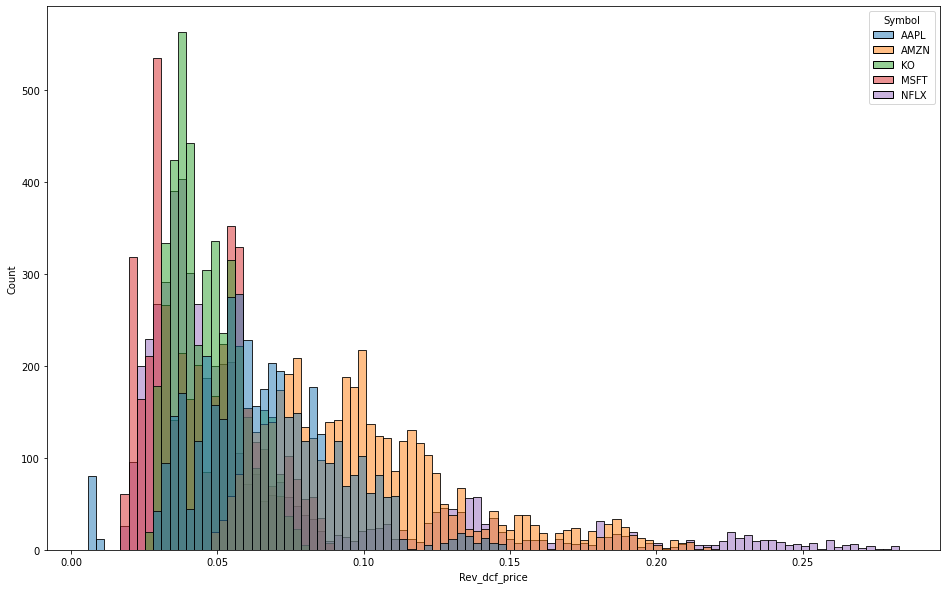

In [652]:
# TODO: normalize for each symbol? -> make comparable!
# TODO: THE FUCK IS WRONG WITH NFLX?
fig, ax = plt.subplots(figsize=(16,10))
sns.histplot(data=df_val, x='Rev_dcf_price', hue='Symbol')

## Valuation - inverse DCF

<AxesSubplot:xlabel='Date', ylabel='Close'>

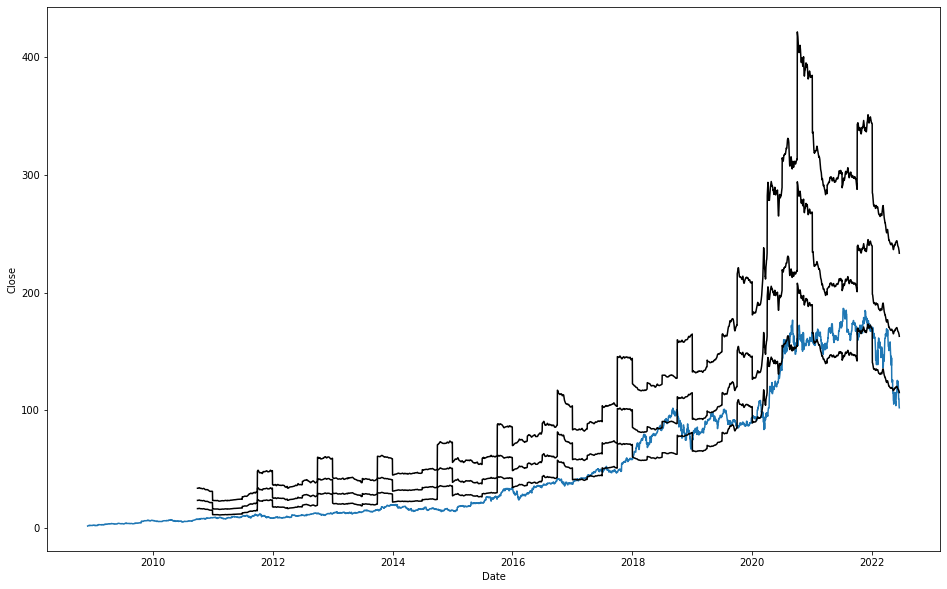

In [653]:
# Sector specific quantiles?
df_plot = df_val.assign(
    val_25 = lambda x: x['Rev_dcf'] / x['Shares Outstanding'] / np.nanquantile(df_val.Rev_dcf_price, .25),
    val_50 = lambda x: x['Rev_dcf'] / x['Shares Outstanding'] / np.nanquantile(df_val.Rev_dcf_price, .5),
    val_75 = lambda x: x['Rev_dcf'] / x['Shares Outstanding'] / np.nanquantile(df_val.Rev_dcf_price, .75)
)

# TODO: compare to avg profit/rev !! as factor!!!


sym = 'AMZN'

fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(data=df_plot[df_plot.Symbol==sym], x='Date', y='Close')
sns.lineplot(data=df_plot[df_plot.Symbol==sym], x='Date', y='val_25', color='black')
sns.lineplot(data=df_plot[df_plot.Symbol==sym], x='Date', y='val_50', color='black')
sns.lineplot(data=df_plot[df_plot.Symbol==sym], x='Date', y='val_75', color='black')
# plt.ylim((0, df_plot[df_plot.Symbol==sym].Close.max() * 1.1))

<AxesSubplot:xlabel='Date', ylabel='Revenue'>

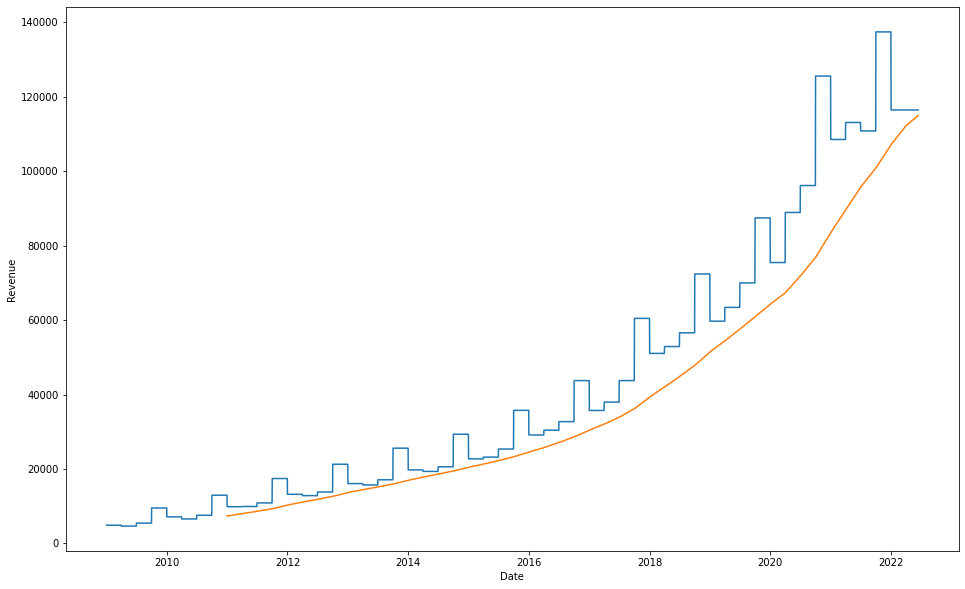

In [658]:
fig, ax = plt.subplots(figsize=(16,10))
df_plot['Rev_avg'] = df_plot['Revenue'].rolling(365*2).mean()
sns.lineplot(data=df_plot[df_plot.Symbol==sym], x='Date', y='Revenue')
sns.lineplot(data=df_plot[df_plot.Symbol==sym], x='Date', y='Rev_avg')

## Scenario simulation

Simulate different interest and valuation scenarios

* Intrest rate of 4 or 5% !!!
* Growth rate -> normal vs pessimistic vs very pessimistic scenario

Idea: For different interest rate scenarios, if the company's revenue keeps growing at the last rate, what is the most probable price?